<a href="https://colab.research.google.com/github/alaa-shehab/Head-Pose-Estimation/blob/main/ML1_Head_Pose_Estimation_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Thanks to:
- Amira Adel Foda (intake 42 - smart village branch - group 2)
- Asmaa Said (intake 42 - smart village branch - group 2)
- Marawan Mohamed (intake 42 - Alex. branch - group 2)


### Installing MediaPipe

In [ ]:
%%capture
!pip install mediapipe

### Required Libraries

In [1]:
import numpy as np
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import pandas as pd
import mediapipe
import warnings
warnings.filterwarnings('ignore')
from google.colab.patches import cv2_imshow

### Dowlining Data

In [ ]:
# link of the data
# http://www.cbsr.ia.ac.cn/users/xiangyuzhu/projects/3DDFA/Database/AFLW2000-3D.zip

In [ ]:
# Loading AFLW2000 Data
%%capture
if os.path.isfile('/content/AFLW2000-3D.zip') == False:
  !gdown --id  1fP3zvSCYjll_o_m7S12nvQLZ9MnsEoap
  !unzip /content/AFLW2000-3D.zip


In [2]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

### Preparing Data

In [3]:
import glob

img_dir = '/content/AFLW2000/*.jpg'
mat_dir = '/content/AFLW2000/*.mat'

image_files = glob.glob(img_dir)
mat_files = glob.glob(mat_dir)


In [4]:
# choosing random image
features = []
poses = []
nose = []
chin = []
x_features = []
y_features = []
faceModule = mediapipe.solutions.face_mesh

# loading image and its corresponding mat file
with faceModule.FaceMesh(static_image_mode=True) as faces:
    for image, mat_file in zip(sorted(image_files), sorted(mat_files)):
        image_x = []
        image_y = []
        img = cv2.imread(image)
        results = faces.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

        if results.multi_face_landmarks:
            if os.path.splitext(image)[0] == os.path.splitext(mat_file)[0]:
                mat = sio.loadmat(mat_file)
                poses.append(mat['Pose_Para'][0][:3])

            for face in results.multi_face_landmarks:

                for idx, landmark in enumerate(face.landmark):

                    x = landmark.x
                    y = landmark.y

                    image_x.append(x)
                    image_y.append(y)


                    if idx == 1:
                        nose.append([x, y])
                    elif idx == 152:
                        chin.append([x, y])



                x_features.append(image_x)
                y_features.append(image_y)


In [5]:
features = []
features = np.hstack([x_features, y_features])

In [6]:
nose = np.array(nose)

In [7]:
chin = np.array(chin)

In [8]:
centered_x = np.array(x_features) - nose[:,0].reshape(-1,1)
centered_y = np.array(y_features) - nose[:,1].reshape(-1,1)

In [9]:
df = pd.DataFrame(centered_x)

In [10]:
df

,0,1,2,3,4,5,6,7,8,9,...,458,459,460,461,462,463,464,465,466,467
0,-0.003543,0.0,0.000608,-0.009464,0.001364,4.439384e-03,0.013999,-0.125516,0.019435,0.021375,...,0.020202,0.031218,0.052639,0.016129,0.014511,0.070518,0.059243,0.052235,0.176474,0.186897
1,0.024229,0.0,0.031566,0.018721,-0.001516,9.507179e-03,0.046927,0.047139,0.056855,0.054796,...,0.024827,0.029342,0.064762,0.019547,0.028106,0.105195,0.094120,0.083385,0.167178,0.176787
2,-0.003530,0.0,-0.003012,-0.010264,0.000131,-9.746850e-04,-0.004974,-0.074134,-0.006653,-0.006827,...,0.007334,0.011718,0.017897,0.006202,0.004513,0.013085,0.009006,0.007312,0.052077,0.056315
3,0.034401,0.0,0.019983,-0.025088,-0.007765,-1.240668e-02,-0.018161,-0.107944,-0.031873,-0.041470,...,0.025930,0.032691,0.063698,0.021744,0.025289,0.038046,0.028210,0.021064,0.126094,0.133149
4,0.017510,0.0,0.007027,-0.025361,-0.004529,-9.133726e-03,-0.018460,-0.134770,-0.024065,-0.028712,...,0.018863,0.026586,0.047360,0.016296,0.015960,0.027772,0.018014,0.012938,0.109755,0.118581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1848,-0.017394,0.0,-0.014022,-0.021187,0.002506,4.172325e-07,-0.011757,-0.172699,-0.014296,-0.012343,...,0.009465,0.018873,0.022846,0.007964,0.002310,0.016343,0.009038,0.007237,0.096224,0.102929
1849,-0.021379,0.0,-0.015997,-0.019701,0.003207,1.438320e-03,-0.008581,-0.166479,-0.008748,-0.005852,...,0.009779,0.019355,0.023437,0.008038,0.002470,0.016814,0.010706,0.009687,0.094514,0.102468
1850,-0.018034,0.0,-0.010614,-0.001460,0.005185,9.545743e-03,0.020184,-0.095862,0.032612,0.040196,...,0.011729,0.022248,0.031742,0.008742,0.004656,0.059450,0.049798,0.044495,0.129610,0.138876
1851,-0.009009,0.0,-0.003344,-0.010562,0.002792,5.800664e-03,0.012746,-0.146150,0.018244,0.021437,...,0.018928,0.030519,0.047378,0.015256,0.012469,0.070122,0.057071,0.049653,0.173337,0.183966


In [11]:
distance = np.sqrt((nose[:, 0] - chin[:, 0]) ** 2 + (nose[:, 1] - chin[:, 1]) ** 2)
distance[distance == 0] = 1

In [12]:
normalized_x = centered_x/distance.reshape(-1,1)
normalized_y = centered_y/distance.reshape(-1,1)

In [13]:
normalized = pd.DataFrame(normalized_x)

In [14]:
features = []

In [15]:
normalized_x = np.array(normalized_x)
normalized_y = np.array(normalized_y)

features = np.hstack([normalized_x, normalized_y])

In [16]:
features_df = pd.DataFrame(features)

In [17]:
features_df

,0,1,2,3,4,5,6,7,8,9,...,926,927,928,929,930,931,932,933,934,935
0,-0.018852,0.0,0.003236,-0.050351,0.007259,0.023618,0.074478,-0.667768,0.103397,0.113717,...,0.007330,-0.022768,-0.015969,0.024269,0.025193,-0.822416,-0.781576,-0.741364,-0.895837,-0.934839
1,0.138041,0.0,0.179845,0.106660,-0.008637,0.054166,0.267360,0.268567,0.323926,0.312195,...,0.043206,0.019102,0.098784,0.046183,0.071900,-0.485956,-0.458790,-0.440621,-0.524195,-0.551868
2,-0.036167,0.0,-0.030855,-0.105149,0.001346,-0.009985,-0.050959,-0.759464,-0.068157,-0.069937,...,0.011259,-0.018911,-0.010553,0.024148,0.033236,-0.601383,-0.569894,-0.544548,-0.649772,-0.683301
3,0.184964,0.0,0.107441,-0.134894,-0.041753,-0.066708,-0.097645,-0.580387,-0.171372,-0.222976,...,-0.032250,-0.075959,-0.115414,-0.010755,-0.008673,-0.822403,-0.770528,-0.727266,-1.066225,-1.125301
4,0.076507,0.0,0.030704,-0.110813,-0.019788,-0.039909,-0.080660,-0.588866,-0.105150,-0.125453,...,0.008826,-0.026157,0.009880,0.020118,0.038680,-0.536937,-0.507487,-0.489883,-0.664578,-0.682593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1848,-0.095746,0.0,-0.077184,-0.116625,0.013796,0.000002,-0.064717,-0.950638,-0.078691,-0.067944,...,0.010904,-0.025579,0.006944,0.025637,0.038616,-0.708236,-0.674614,-0.646147,-0.804009,-0.832053
1849,-0.109325,0.0,-0.081805,-0.100744,0.016400,0.007355,-0.043879,-0.851310,-0.044736,-0.029924,...,0.010574,-0.024911,-0.005777,0.026184,0.034759,-0.727055,-0.690496,-0.658761,-0.795007,-0.840669
1850,-0.084971,0.0,-0.050011,-0.006879,0.024433,0.044977,0.095102,-0.451680,0.153659,0.189392,...,0.053483,0.035677,0.097620,0.055858,0.072798,-0.425947,-0.415686,-0.406506,-0.377094,-0.412571
1851,-0.048183,0.0,-0.017882,-0.056486,0.014933,0.031023,0.068170,-0.781639,0.097573,0.114651,...,0.021488,-0.008260,0.020774,0.035398,0.042692,-0.787839,-0.754294,-0.722160,-0.833005,-0.873595


In [18]:
poses_df = pd.DataFrame(poses)

## Splitting Data

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_val_test, y_train, y_val_test = train_test_split(features, poses, train_size=0.80, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.10, random_state=42)

In [20]:
y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)

In [21]:
pitch_train = y_train[:,0]
yaw_train = y_train[:,1]
roll_train = y_train[:,2]

In [22]:
pitch_val = y_val[:,0]
yaw_val = y_val[:,1]
roll_val = y_val[:,2]

In [23]:
pitch_test = y_test[:,0]
yaw_test = y_test[:,1]
roll_test = y_test[:,2]

## Training Models

In [ ]:
from sklearn.linear_model import LinearRegression

In [26]:
from sklearn.metrics import mean_absolute_error

### Linear Regression

In [ ]:
lr_pitch = LinearRegression()
lr_pitch.fit(X_train, pitch_train)

LinearRegression()

In [ ]:
lr_pitch.score(X_val, pitch_val)

-2.319877131617806

In [ ]:
lr_pitch.score(X_test, pitch_test)

-3.1419326956044875

### SVM

In [24]:
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


In [27]:
svm_model = SVR()

param = {
    'kernel': ['rbf'],
    'C': [0.01, 0.1, 1, 10],
    'gamma': [0.01, 0.1, 1, 10],
}

pitch_search = GridSearchCV(estimator=svm_model, param_grid=param)
pitch_search.fit(X_train, pitch_train)

best_params = pitch_search.best_params_

best_svm_model = pitch_search.best_estimator_

y_pred = best_svm_model.predict(X_val)
mae = mean_absolute_error(pitch_val, y_pred)
print("MAE on Validation Set:", mae)


MAE on Validation Set: 0.08658396681725145


In [28]:
print("Train acc: ", best_svm_model.score(X_train, pitch_train))
print("Validation acc: ", best_svm_model.score(X_val, pitch_val))

Train acc:  0.28376504883813136
Validation acc:  0.6398235504817626


In [29]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVR
from sklearn.metrics import make_scorer, mean_absolute_error
from scipy.stats import uniform, randint

# svm_model = SVR()

param = {
    'kernel': ['rbf'],
    'C': [0.01, 0.1, 1, 10],
    'gamma': [0.01, 0.1, 1, 10],
}

yaw_search =  GridSearchCV(estimator=svm_model, param_grid=param)
yaw_search.fit(X_train, yaw_train)

yaw_svm_model = yaw_search.best_estimator_



In [30]:
print("Train acc: ", yaw_svm_model.score(X_train, yaw_train))
print("Validation acc: ", yaw_svm_model.score(X_val, yaw_val))

Train acc:  0.8650313197117327
Validation acc:  0.9463355995472097


In [31]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVR
from sklearn.metrics import make_scorer, mean_absolute_error
from scipy.stats import uniform, randint

# Define the SVM model
# svm_model = SVR()

param = {
    'kernel': ['rbf'],
    'C': [0.01, 0.1, 1, 10],
    'gamma': [0.01, 0.1, 1, 10],
}


roll_search = GridSearchCV(estimator=svm_model, param_grid=param)
roll_search.fit(X_train, roll_train)


roll_svm_model = roll_search.best_estimator_

In [32]:
print("Train acc: ", roll_svm_model.score(X_train, roll_train))
print("Validation acc: ", roll_svm_model.score(X_val, roll_val))

Train acc:  0.3078439075226159
Validation acc:  0.8556130440894036


In [33]:
from sklearn.metrics import f1_score
pitch_pred = best_svm_model.predict(X_val)
yaw_pred = yaw_svm_model.predict(X_val)
roll_pred = roll_svm_model.predict(X_val)

print("Pitch: ", mean_absolute_error(pitch_val, pitch_pred))
print("Yaw: ", mean_absolute_error(yaw_val, yaw_pred))
print("Roll: ", mean_absolute_error(roll_val, roll_pred))

Pitch:  0.08658396681725145
Yaw:  0.061364434709814085
Roll:  0.05845621563438022


In [34]:
pitch_pred = best_svm_model.predict(X_test)
yaw_pred = yaw_svm_model.predict(X_test)
roll_pred = roll_svm_model.predict(X_test)

print("Pitch: ", mean_absolute_error(pitch_test, pitch_pred))
print("Yaw: ", mean_absolute_error(yaw_test, yaw_pred))
print("Roll: ", mean_absolute_error(roll_test, roll_pred))

Pitch:  0.09724425186617029
Yaw:  0.08179685419682442
Roll:  0.04495132511650009


In [35]:
# choosing random image
features = []
poses = []
nose = []
chin = []
x_features = []
y_features = []
new_df = []
faceModule = mediapipe.solutions.face_mesh

# loading image and its corresponding mat file
with faceModule.FaceMesh(static_image_mode=True) as faces:
        img = cv2.imread('/content/AFLW2000/image00854.jpg')
        results = faces.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        image_x = image_y = []

        if results.multi_face_landmarks:

            for face in results.multi_face_landmarks:

                for idx, landmark in enumerate(face.landmark):

                    x = landmark.x
                    y = landmark.y

                    # image_x.append(x)
                    # image_y.append(y)


                    if idx == 1:
                        nose.append([x, y])
                    elif idx == 152:
                        chin.append([x, y])



                    x_features.append(x)
                    y_features.append(y)


In [ ]:
len(x_features)

468

In [ ]:
nose = np.array(nose)

In [ ]:
chin = np.array(chin)

In [ ]:
centered_x = np.array(x_features) - nose[:,0].reshape(-1,1)
centered_y = np.array(y_features) - nose[:,1].reshape(-1,1)

In [ ]:
len(centered_x)

1

In [ ]:
distance = np.sqrt((nose[:, 0] - chin[:, 0]) ** 2 + (nose[:, 1] - chin[:, 1]) ** 2)
distance[distance == 0] = 1

In [ ]:
normalized_x = centered_x/distance.reshape(-1,1)
normalized_y = centered_y/distance.reshape(-1,1)

In [ ]:
normalized_x = np.array(normalized_x)
normalized_y = np.array(normalized_y)

new_df = np.hstack([normalized_x, normalized_y])

In [ ]:
len(new_df)

1

In [ ]:
df = pd.DataFrame(new_df)

In [ ]:
df

,0,1,2,3,4,5,6,7,8,9,...,926,927,928,929,930,931,932,933,934,935
0,0.036392,0.0,0.022712,-0.073765,-0.007816,-0.012402,-0.019898,-0.516362,-0.034704,-0.046935,...,0.048518,0.0213,0.118127,0.047129,0.083439,-0.187427,-0.180902,-0.187354,-0.213697,-0.249872


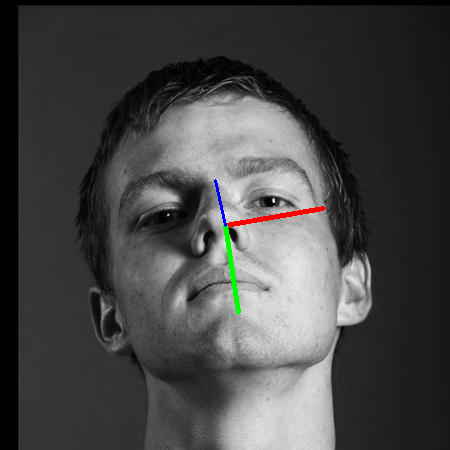

In [ ]:
image = cv2.imread('/content/AFLW2000/image00854.jpg')
new_df = np.array(new_df).reshape(1, -1)
pitch = best_svm_model.predict(new_df)
yaw = yaw_svm_model.predict(new_df)
roll = roll_svm_model.predict(new_df)
cv2_imshow(draw_axis(image,pitch,yaw,roll))

In [36]:
def get_keypoints(frame):
    faceModule = mediapipe.solutions.face_mesh
    nose = []
    chin = []
    features = []
    image_x = []
    image_y = []

    with faceModule.FaceMesh(static_image_mode=True) as faces:
        results = faces.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

        if results.multi_face_landmarks:

            for face in results.multi_face_landmarks:


                for idx, landmark in enumerate(face.landmark):

                    x = landmark.x
                    y = landmark.y

                    if idx == 1:
                        nose.append([x, y])
                    elif idx == 152:
                        chin.append([x, y])



                    image_x.append(x)
                    image_y.append(y)

    if image_x and image_y and nose:
      nose = np.array(nose)
      chin = np.array(chin)

      centered_x = np.array(image_x) - nose[:,0].reshape(-1,1)
      centered_y = np.array(image_y) - nose[:,1].reshape(-1,1)


      distance = np.sqrt((nose[:, 0] - chin[:, 0]) ** 2 + (nose[:, 1] - chin[:, 1]) ** 2)
      distance[distance == 0] = 1

      normalized_x = centered_x / distance.reshape(-1,1)
      normalized_y = centered_y / distance.reshape(-1,1)

      normalized_x = np.array(normalized_x)
      normalized_y = np.array(normalized_y)

      features = np.hstack([normalized_x, normalized_y])
    else:
      features = []
      nose = []
      chin = []

    return features, nose



In [37]:
def pose_predict(frame, pitch, yaw, roll):
  features, nose = get_keypoints(frame)
  if frame.shape[0] == 0 or len(features) == 0:
        return None, None, None, None
  new_df = np.array(features).reshape(1, -1)
  pitch = pitch.predict(new_df)
  yaw = yaw.predict(new_df)
  roll = roll.predict(new_df)

  return nose, pitch, yaw, roll



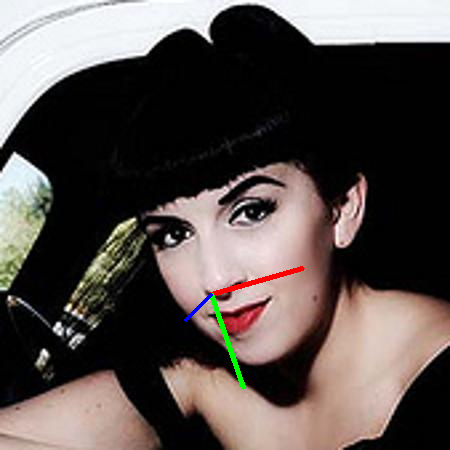

In [38]:
img = '/content/AFLW2000/image00008.jpg'
frame = cv2.imread(img)
nose, pitch, yaw, roll = pose_predict(frame, best_svm_model, yaw_svm_model, roll_svm_model)
cv2_imshow(draw_axis(frame, pitch, yaw,roll, nose[:,0]*frame.shape[1], nose[:,1]*frame.shape[0]))

In [49]:
video_file = '/content/Jake Makes the Criminals Sing _ Cold Open _ Brooklyn Nine Nine.mp4'
cap = cv2.VideoCapture(video_file)
output_video = 'output.avi'
video_writer = cv2.VideoWriter(output_video, cv2.VideoWriter_fourcc(*'MJPG'), int(cap.get(cv2.CAP_PROP_FPS)), (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))))

while True:
    ret, frame = cap.read()
    if not ret:
        break
    # cv2_imshow(frame)
    try:
      nose, pitch, yaw, roll = pose_predict(frame, best_svm_model, yaw_svm_model, roll_svm_model)
      if pitch and yaw and roll:
        draw_axis(frame, pitch, yaw,roll, nose[:,0]*frame.shape[1], nose[:,1]*frame.shape[0])
      video_writer.write(frame)
    except Exception as e:
      print(e)

cap.release()
video_writer.release()


In [53]:
!pip install imageio==2.4.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for imageio: filename=imageio-2.4.1-py3-none-any.whl size=3303885 sha256=752b91fd8d3830ea272c0d1d33111b7cfaa8fa88b414c4b94b05be7d76c6ea9e
  Stored in directory: /root/.cache/pip/wheels/96/5d/ce/bdbdb04744dac03906336eb0d01ff1e222061d3419c55c55f9
Successfully built imageio
  Attempting uninstall: imageio
    Found existing installation: imageio 2.31.6
    Uninstalling imageio-2.31.6:
      Successfully uninstalled imageio-2.31.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
moviepy 1.0.3 requires imageio<3.0,>=2.5; python_version >= "3.4", but you have imageio 2.4.1 which is incompatible.


In [56]:
from moviepy.editor import *

path='/content/output.avi'

clip=VideoFileClip(path)
clip.ipython_display(width=280, maxduration=200)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


### Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint

# Define the Random Forest Regressor
rf_regressor = RandomForestRegressor()

# Define the parameter distributions to sample from
param_distributions = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(5, 50),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20)
}

pitch_search = RandomizedSearchCV(estimator=rf_regressor, param_distributions=param_distributions,
                                   n_iter=100, scoring='neg_mean_absolute_error', cv=5, random_state=42)
pitch_search.fit(X_pitch_train, pitch_train)

# Get the best parameters and best score
best_params = pitch_search.best_params_
best_score = -pitch_search.best_score_

# Print the results
print("Best Parameters:", best_params)
print("Best Score (MAE):", best_score)

# Get the best model
pitch_rf = pitch_search.best_estimator_

# Evaluate the best model on the validation set
pitch_pred = pitch_rf.predict(X_pitch_val)
mae = mean_absolute_error(pitch_val, y_pred)
print("MAE on Validation Set:", mae)
